# Comparing Sigmoid and ReLU Performance on Different Models

## Fashion MNIST Dataset Download Commands

In [1]:
# Note: Forwarded stderr to /dev/null so no output will be shown but it works! :)
!wget -O train-images-idx3-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz 2> /dev/null
!wget -O train-labels-idx1-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz 2> /dev/null
!wget -O t10k-images-idx3-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz 2> /dev/null
!wget -O t10k-labels-idx1-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz 2> /dev/null

## Libraries

In [19]:
# -*- coding: utf-8 -*-
import os
import gzip
import torch as th
import numpy as np
import matplotlib.pyplot as plt

## Function that Loads Dataset

In [20]:
def load_mnist(dataset="training", path="."):
    if dataset not in  ['training', 'testing']:
        raise ValueError("dataset has to be either 'training' or 'testing'")

    if dataset == 'training':
        kind = 'train'
    else:
        kind = 't10k'

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8).astype(np.float32)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28).astype(np.float32)

    return th.from_numpy(images), th.from_numpy(labels)

## Dataset Class, Network Class, Train and Evaluation Function

In [76]:
class DatasetFashion():
    def __init__(self, option, crossvalidation=None, shuffle_mask=None, split_ratio=0.8, path='./'):
        
        if option=="testing":
                X,y = load_mnist("testing", path)
        else:
                X,y = load_mnist("training", path)

        self.images = X.reshape([-1, 28*28])
        self.images = self.images/255.0
        self.labels = y.type(th.long)
        self.shuffle_mask = shuffle_mask
        self.split_ratio = split_ratio

        if option=="training":
                
                # shuffle the data before splitting
                indices = th.randperm(len(self.labels))
                self.images = self.images[indices]
                self.labels = self.labels[indices]

                self.shuffle_mask = indices

                if crossvalidation:
                        splitSize = len(self.labels)//crossvalidation[0]
                        chunks = th.split(th.arange(len(self.labels)), splitSize, dim=0)
                        validation = chunks[crossvalidation[1]]
                        training = th.cat([c for j, c in enumerate(chunks) if j!=crossvalidation[1]], dim=0)
                        self.validationImages = self.images[validation]
                        self.validationLabels = self.labels[validation]
                        self.trainingImages = self.images[training]
                        self.trainingLabels = self.labels[training]
                
                else:
                        #split the data
                        split_value = int(len(self.images)*split_ratio)

                        self.images = self.images[:split_value]
                        self.labels = self.labels[:split_value]

        elif option=="validation":
                self.images = self.images[shuffle_mask]
                self.labels = self.labels[shuffle_mask]
                print("len: ", len(self.images))

                #split the data
                split_value = int(len(self.images)*(split_ratio))
                print("split_value= ", split_value)

                self.images = self.images[split_value:]
                self.labels = self.labels[split_value:]
                     
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

class Network(th.nn.Module):
    def __init__(self, num_inputs, num_classes, num_neurons=(50,50), activation=[th.nn.Sigmoid(),th.nn.Sigmoid()]):
        super(Network, self).__init__()
        self.activation = activation
        
        self.layers = th.nn.ModuleList()
        self.layers.append(th.nn.Linear(num_inputs, num_neurons[0], True))
        self.layers.append(activation[0])
        for i in range(len(num_neurons)-1):
            self.layers.append(th.nn.Linear(num_neurons[i], num_neurons[i+1], True))
            self.layers.append(activation[i+1])
        self.layers.append(th.nn.Linear(num_neurons[-1], num_classes, True))
        self.layers.append(th.nn.LogSoftmax(dim=1))   #If CrossEntropyLoss function is used as loss function, CrossEntropyLoss takes care of both logSoftmax and NLL loss
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

"""
reg_type   regularization type: l1 or l2
"""
def train(model, dataloader, optimizer, lossFunc, debug=False):
    
    loss_hist = np.array([])
    for index, (trainingImages,trainingLabels) in enumerate(dataloader):
        optimizer.zero_grad()

        prediction = model(trainingImages.reshape(-1, 28*28))

        loss = lossFunc(prediction, trainingLabels)
        
        loss_hist = np.append(loss_hist, loss.item())
        loss.backward()
        optimizer.step()
        if debug:
            with th.no_grad():
                if index % 100 == 0:
                    print('Train {}/{} Loss {:.6f}'.format(index, len(dataloader), loss.item()))
    return loss_hist

def evaluate(model, val_dataloader, lossFunction):

    total_loss = 0
    total_accuracy = 0
    for (val_images, val_labels) in val_dataloader:
        prediction = model(val_images.reshape(-1, 28*28))
        loss = lossFunction(prediction, val_labels.squeeze()).item() / len(val_images)
        total_loss += loss

        pred_label = th.argmax(prediction, dim=1)
        #print("----------", pred_label[0:10], labels.squeeze()[0:10], pred_label[0:10] == labels.squeeze()[0:10])
        accuracy = ((pred_label == val_labels).sum().item()) / len(val_images)
        #accuracy = th.sum(pred_label == labels.squeeze()) / len(labels)
        total_accuracy += accuracy

    avg_loss = total_loss / len(val_dataloader)
    avg_accuracy = total_accuracy / len(val_dataloader)
    return avg_loss, avg_accuracy

## Visualizing Training Data

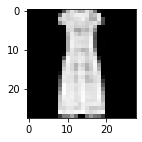

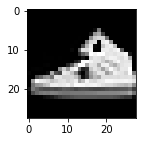

In [77]:
dataset = DatasetFashion(option="training")
dataloader = th.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

for index, (images,labels) in enumerate(dataloader):
    plt.figure(figsize=(2,2))
    plt.imshow(images.reshape(28,28), cmap='gray')
    if index == 1:
        break

## Training a Simple Linear Network

len:  60000
split_value=  48000
epoch  1  validation loss:  0.055504481226205826  validation accuracy:  0.5833333333333334
epoch  2  validation loss:  0.04114597831169764  validation accuracy:  0.6464166666666666
epoch  3  validation loss:  0.03386182360351086  validation accuracy:  0.677
epoch  4  validation loss:  0.029661051794886588  validation accuracy:  0.6966666666666667
epoch  5  validation loss:  0.02701677074531714  validation accuracy:  0.71025
epoch  6  validation loss:  0.02516260583947102  validation accuracy:  0.72225
epoch  7  validation loss:  0.023798570255438488  validation accuracy:  0.7355833333333334
epoch  8  validation loss:  0.02275567239522934  validation accuracy:  0.7438333333333333
epoch  9  validation loss:  0.021889863304793835  validation accuracy:  0.751
epoch  10  validation loss:  0.02117945398638646  validation accuracy:  0.75725
epoch  11  validation loss:  0.02056882570932309  validation accuracy:  0.76275
epoch  12  validation loss:  0.02000238634

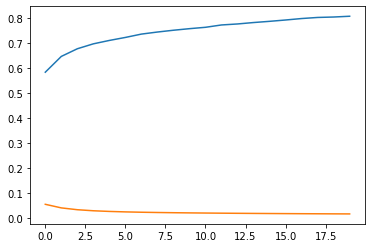

In [79]:
batch_size = 32

train_dataset = DatasetFashion(option="training")
dataloader = th.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DatasetFashion(option="validation", shuffle_mask=train_dataset.shuffle_mask)
val_dataloader = th.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

lossFunction = th.nn.NLLLoss()

model = Network(num_inputs=28*28, num_classes=10, num_neurons=(50,))
optimizer = th.optim.SGD(model.parameters(), lr=0.005)

epoch = 20

loss_hist = np.array([])   
val_loss_hist = np.array([])
val_acc_hist = np.array([])
for i in range(epoch):
    #training
    loss_hist_per_epoch = train(model, dataloader, optimizer, lossFunction, debug=False)
    #evaluation
    avg_loss, avg_accuracy = evaluate(model, val_dataloader, lossFunction)

    #loss and accuracy histories are kept
    loss_hist = np.hstack((loss_hist, loss_hist_per_epoch))
    val_loss_hist = np.hstack((val_loss_hist, avg_loss))
    val_acc_hist = np.hstack((val_acc_hist, avg_accuracy))

    print("epoch ", i+1, " validation loss: ", avg_loss, " validation accuracy: ", avg_accuracy)

plt.plot(val_acc_hist, label="validation acc")
plt.plot(val_loss_hist, label="validation loss")
plt.legend()

## Experiment 1: Comparing Models' Performance Using Sigmoid

In [109]:
model1 = Network(28*28, 10, num_neurons=(50,), activation=[th.nn.Sigmoid()])
model2 = Network(28*28, 10, num_neurons=(50,30), activation=[th.nn.Sigmoid(),th.nn.Sigmoid()])
model3 = Network(28*28, 10, num_neurons=(50,30,30), activation=[th.nn.Sigmoid(),th.nn.Sigmoid(),th.nn.Sigmoid()])
model4 = Network(28*28, 10, num_neurons=(50,30,30,30), activation=[th.nn.Sigmoid(),th.nn.Sigmoid(),th.nn.Sigmoid(),th.nn.Sigmoid()])
models = [model1, model2, model3, model4]

batch_size = 32

train_dataset = DatasetFashion(option="training")
dataloader = th.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DatasetFashion(option="validation", shuffle_mask=train_dataset.shuffle_mask)
val_dataloader = th.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

epoch = 20

models_loss_hist = []
models_val_loss_hist = []
models_val_acc_hist = []

for model in models:

    lossFunction = th.nn.NLLLoss()
    optimizer = th.optim.SGD(model.parameters(), lr=0.005)

    loss_hist = np.array([])   
    val_loss_hist = np.array([])
    val_acc_hist = np.array([])
    
    for i in range(epoch):
        #training
        loss_hist_per_epoch = train(model, dataloader, optimizer, lossFunction, debug=False)

        #evaluation
        avg_loss, avg_accuracy = evaluate(model, val_dataloader, lossFunction)

        #loss and accuracy histories are kept
        loss_hist = np.hstack((loss_hist, loss_hist_per_epoch))
        val_loss_hist = np.hstack((val_loss_hist, avg_loss))
        val_acc_hist = np.hstack((val_acc_hist, avg_accuracy))

        print("epoch ", i+1, " validation loss: ", avg_loss, " validation accuracy: ", avg_accuracy)

    models_loss_hist.append(loss_hist)
    models_val_loss_hist.append(val_loss_hist)
    models_val_acc_hist.append(val_acc_hist)

len:  60000
split_value=  48000
epoch  1  validation loss:  0.05472321132818858  validation accuracy:  0.555
epoch  2  validation loss:  0.042017328153053916  validation accuracy:  0.6195833333333334
epoch  3  validation loss:  0.03489812239011129  validation accuracy:  0.6835
epoch  4  validation loss:  0.030475612074136734  validation accuracy:  0.704
epoch  5  validation loss:  0.027545175542434058  validation accuracy:  0.7215833333333334
epoch  6  validation loss:  0.025493833144505818  validation accuracy:  0.73275
epoch  7  validation loss:  0.023991809037824472  validation accuracy:  0.74375
epoch  8  validation loss:  0.022830287958184876  validation accuracy:  0.7484166666666666
epoch  9  validation loss:  0.021925794559220474  validation accuracy:  0.7579166666666667
epoch  10  validation loss:  0.02115812627474467  validation accuracy:  0.7630833333333333
epoch  11  validation loss:  0.020497754896680515  validation accuracy:  0.77125
epoch  12  validation loss:  0.01992195

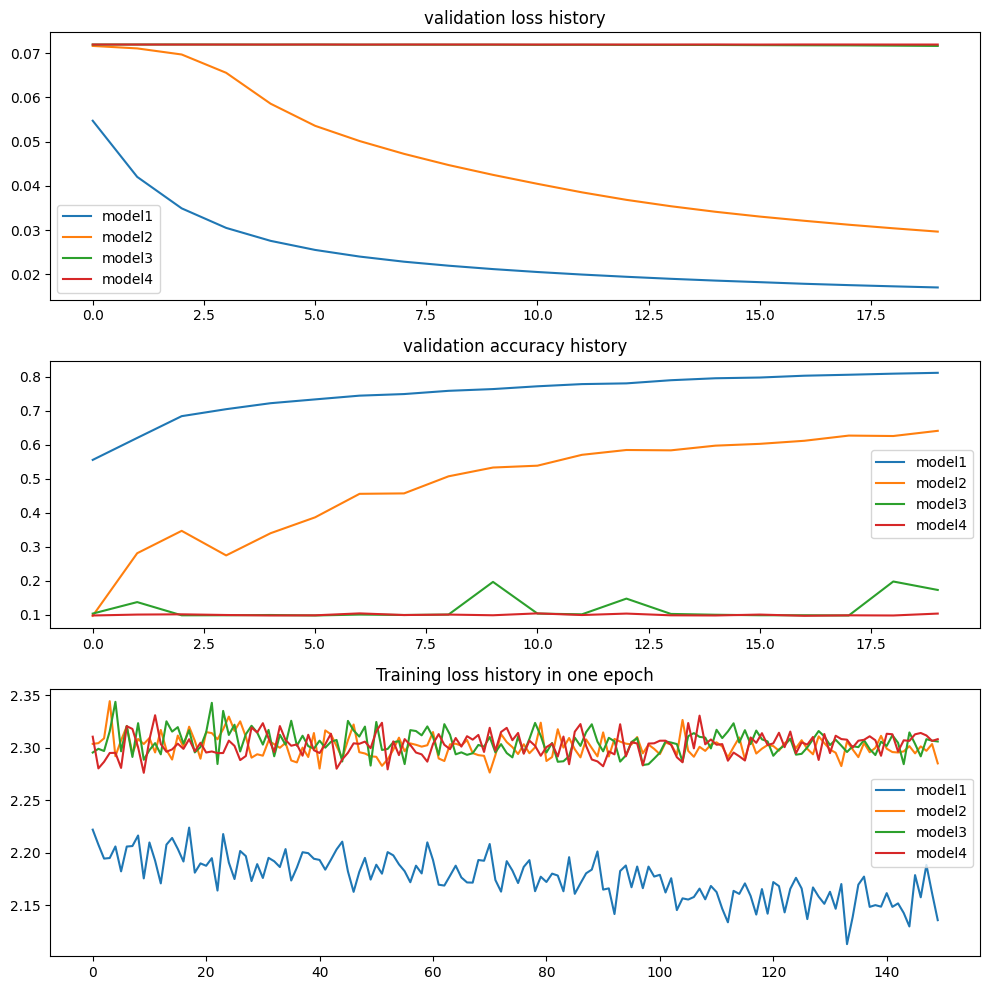

In [117]:
labels = ["model1", "model2", "model3", "model4"]

epoch = 2   #which epoch loss data you want to visualize
num_of_batch = 150 #got the info from the prints

fig, axs = plt.subplots(3, figsize=(10,10), dpi=100, sharex=False, sharey=False)

for i in range(4):
    axs[0].plot(models_val_loss_hist[i], label=labels[i])
axs[0].legend()
axs[0].set_title('validation loss history')

for i in range(4):
    axs[1].plot(models_val_acc_hist[i], label=labels[i])
axs[1].legend()
axs[1].set_title('validation accuracy history')

for i in range(4):
    axs[2].plot(models_loss_hist[i][epoch*num_of_batch : (epoch+1)*num_of_batch], "-", label=labels[i])
axs[2].set_title('Training loss history in one epoch')
axs[2].legend()

fig.tight_layout()

## Evaluating Accuracy and Loss on Test Data

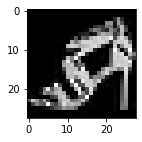

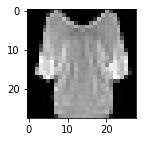

In [8]:
dataset = DatasetFashion(option="testing")
dataloader = th.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

for index, (images,labels) in enumerate(dataloader):
    plt.figure(figsize=(2,2))
    plt.imshow(images.reshape(28,28), cmap='gray')
    if index == 1:
        break

In [64]:
dataset = DatasetFashion(option="testing")
dataloader = th.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

#evaluation
for index, model in enumerate(models):
    avg_loss, avg_accuracy = evaluate(model, val_dataloader, lossFunction)
    print("For model ",index+1, " average loss: ", avg_loss, " average accuracy: ", avg_accuracy)

For model  1  average loss:  0.0168552847398465  average accuracy:  0.8127365591397849
For model  2  average loss:  0.029349358672095885  average accuracy:  0.6483118279569893
For model  3  average loss:  0.07142095425180209  average accuracy:  0.19418279569892472
For model  4  average loss:  0.07197774170611494  average accuracy:  0.10309139784946236


## Experiment 2: Comparing Models' Performance Using ReLU

In [ ]:
model_1 = Network(28*28, 10, num_neurons=(50,), activation=[th.nn.ReLU()])
model_2 = Network(28*28, 10, num_neurons=(50,30), activation=[th.nn.ReLU(),th.nn.ReLU()])
model_3 = Network(28*28, 10, num_neurons=(50,30,30), activation=[th.nn.ReLU(),th.nn.ReLU(),th.nn.ReLU()])
model_4 = Network(28*28, 10, num_neurons=(50,30,30,30), activation=[th.nn.ReLU(),th.nn.ReLU(),th.nn.ReLU(),th.nn.ReLU()])
models2 = [model_1, model_2, model_3, model_4]

batch_size = 32

train_dataset = DatasetFashion(option="training")
dataloader = th.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DatasetFashion(option="validation", shuffle_mask=train_dataset.shuffle_mask)
val_dataloader = th.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

epoch = 20

models_loss_hist2 = []
models_val_loss_hist2 = []
models_val_acc_hist2 = []

for model in models2:

    lossFunction = th.nn.NLLLoss()
    optimizer = th.optim.SGD(model.parameters(), lr=0.005)

    loss_hist = np.array([])   
    val_loss_hist = np.array([])
    val_acc_hist = np.array([])
    for i in range(epoch):
        #training
        loss_hist_per_epoch = train(model, dataloader, optimizer, lossFunction)

        #evaluation
        avg_loss, avg_accuracy = evaluate(model, val_dataloader, lossFunction)

        #loss and accuracy histories are kept
        loss_hist = np.hstack((loss_hist, loss_hist_per_epoch))
        val_loss_hist = np.hstack((val_loss_hist, avg_loss))
        val_acc_hist = np.hstack((val_acc_hist, avg_accuracy))

        print("epoch ", i+1, " validation loss: ", avg_loss, " validation accuracy: ", avg_accuracy)

    models_loss_hist2.append(loss_hist)
    models_val_loss_hist2.append(val_loss_hist)
    models_val_acc_hist2.append(val_acc_hist)

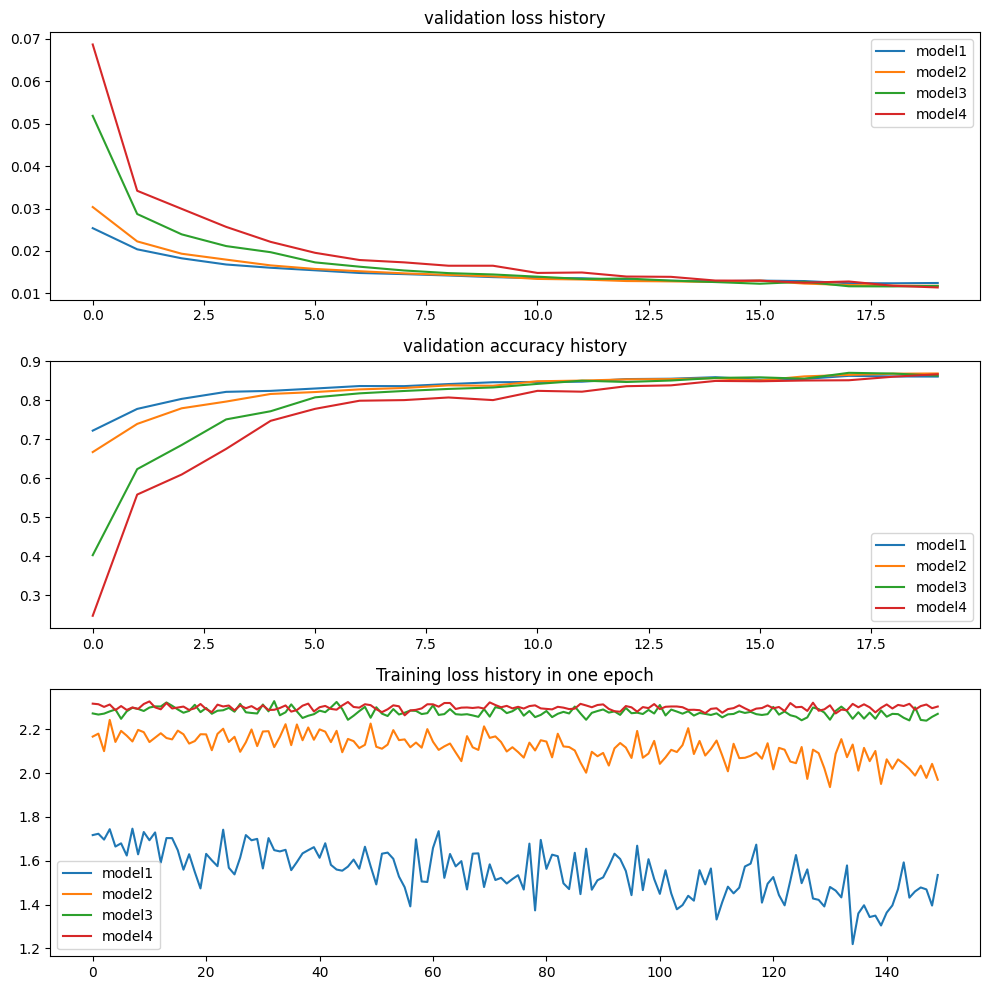

In [116]:
labels = ["model1", "model2", "model3", "model4"]

epoch = 2   #which epoch loss data you want to visualize
num_of_batch = 150 #got the info from the prints

fig, axs = plt.subplots(3, figsize=(10,10), dpi=100, sharex=False, sharey=False)

for i in range(4):
    axs[0].plot(models_val_loss_hist2[i], label=labels[i])
axs[0].legend()
axs[0].set_title('validation loss history')

for i in range(4):
    axs[1].plot(models_val_acc_hist2[i], label=labels[i])
axs[1].legend()
axs[1].set_title('validation accuracy history')

for i in range(4):
    axs[2].plot(models_loss_hist2[i][epoch*num_of_batch : (epoch+1)*num_of_batch], "-", label=labels[i])
axs[2].legend()
axs[2].set_title('Training loss history in one epoch')

fig.tight_layout()

## Experiment 3: Comparing Models' Performance Using Sigmoid and Xavier Initialization

In [101]:
model1 = Network(28*28, 10, num_neurons=(50,), activation=[th.nn.Sigmoid()])
model2 = Network(28*28, 10, num_neurons=(50,30), activation=[th.nn.Sigmoid(),th.nn.Sigmoid()])
model3 = Network(28*28, 10, num_neurons=(50,30,30), activation=[th.nn.Sigmoid(),th.nn.Sigmoid(),th.nn.Sigmoid()])
model4 = Network(28*28, 10, num_neurons=(50,30,30,30), activation=[th.nn.Sigmoid(),th.nn.Sigmoid(),th.nn.Sigmoid(),th.nn.Sigmoid()])
models = [model1, model2, model3, model4]

batch_size = 32

train_dataset = DatasetFashion(option="training")
dataloader = th.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DatasetFashion(option="validation", shuffle_mask=train_dataset.shuffle_mask)
val_dataloader = th.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

epoch = 20

models_loss_hist3 = []
models_val_loss_hist3 = []
models_val_acc_hist3 = []

for model in models:

    lossFunction = th.nn.NLLLoss()

    for name, param in model.named_parameters():
        if 'bias' not in name:
            th.nn.init.xavier_normal_(param)
        
    optimizer = th.optim.SGD(model.parameters(), lr=0.005)

    loss_hist = np.array([])   
    val_loss_hist = np.array([])
    val_acc_hist = np.array([])
    
    for i in range(epoch):
        #training
        loss_hist_per_epoch = train(model, dataloader, optimizer, lossFunction, debug=False)

        #evaluation
        avg_loss, avg_accuracy = evaluate(model, val_dataloader, lossFunction)

        #loss and accuracy histories are kept
        loss_hist = np.hstack((loss_hist, loss_hist_per_epoch))
        val_loss_hist = np.hstack((val_loss_hist, avg_loss))
        val_acc_hist = np.hstack((val_acc_hist, avg_accuracy))

        print("epoch ", i+1, " validation loss: ", avg_loss, " validation accuracy: ", avg_accuracy)

    models_loss_hist3.append(loss_hist)
    models_val_loss_hist3.append(val_loss_hist)
    models_val_acc_hist3.append(val_acc_hist)

len:  60000
split_value=  48000
epoch  1  validation loss:  0.04279301578799884  validation accuracy:  0.7164166666666667
epoch  2  validation loss:  0.03268242584168911  validation accuracy:  0.7381666666666666
epoch  3  validation loss:  0.027767571593324342  validation accuracy:  0.75475
epoch  4  validation loss:  0.024920941447218257  validation accuracy:  0.76075
epoch  5  validation loss:  0.023073002609113852  validation accuracy:  0.76725
epoch  6  validation loss:  0.02172927043835322  validation accuracy:  0.7775
epoch  7  validation loss:  0.0207145737161239  validation accuracy:  0.7855833333333333
epoch  8  validation loss:  0.019887308046221734  validation accuracy:  0.7909166666666667
epoch  9  validation loss:  0.01922182607402404  validation accuracy:  0.7939166666666667
epoch  10  validation loss:  0.018659329004585744  validation accuracy:  0.8006666666666666
epoch  11  validation loss:  0.018136882469058035  validation accuracy:  0.8050833333333334
epoch  12  valid

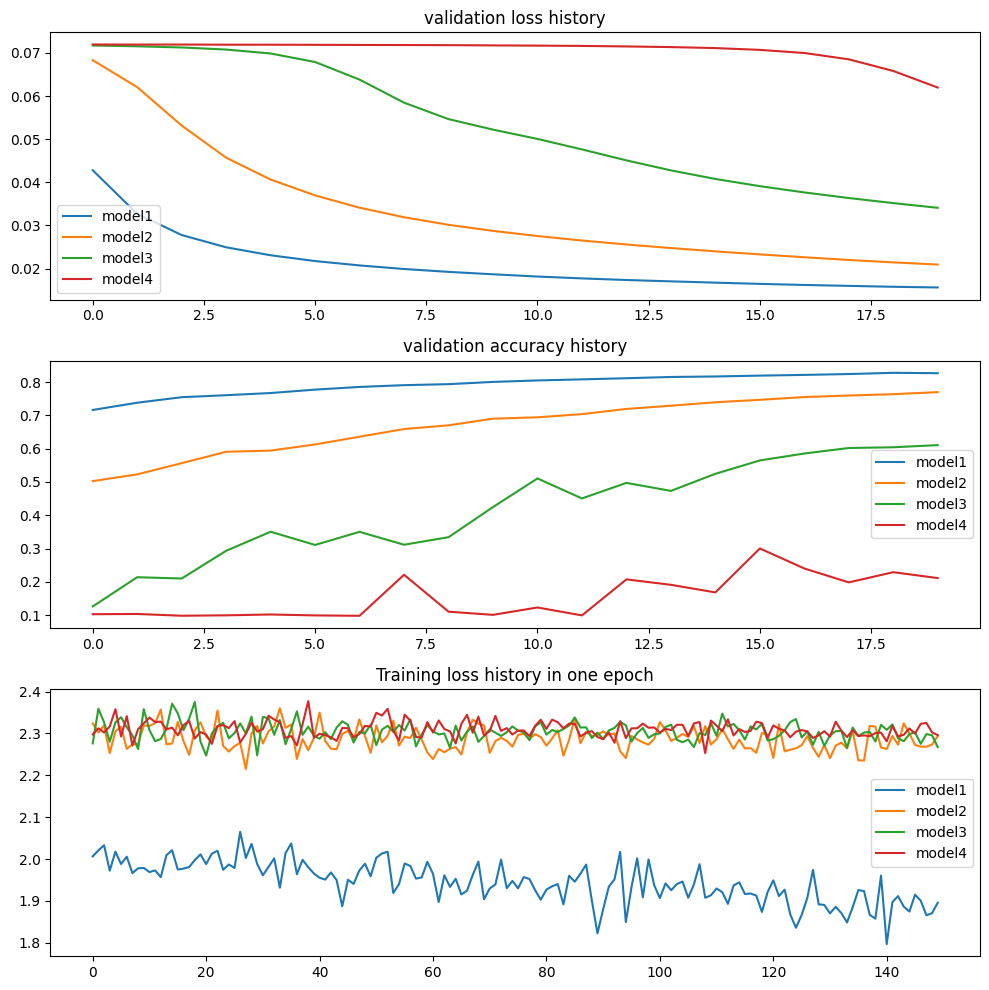

In [115]:
labels = ["model1", "model2", "model3", "model4"]

epoch = 2   #which epoch loss data you want to visualize
num_of_batch = 150 #got the info from the prints

fig, axs = plt.subplots(3, figsize=(10,10), dpi=100, sharex=False, sharey=False)

for i in range(4):
    axs[0].plot(models_val_loss_hist3[i], label=labels[i])
axs[0].legend()
axs[0].set_title('validation loss history')

for i in range(4):
    axs[1].plot(models_val_acc_hist3[i], label=labels[i])
axs[1].legend()
axs[1].set_title('validation accuracy history')

for i in range(4):
    axs[2].plot(models_loss_hist3[i][epoch*num_of_batch : (epoch+1)*num_of_batch], "-", label=labels[i])
axs[2].set_title('Training loss history in one epoch')
axs[2].legend()

fig.tight_layout()

## Distribution of Parameters Initialized with Normal Xavier Initialization:

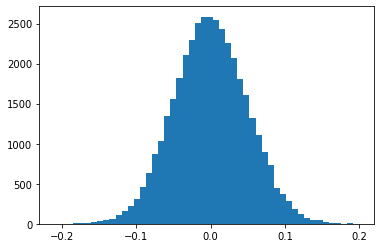

In [188]:
model1 = Network(28*28, 10, num_neurons=(50,), activation=[th.nn.Sigmoid()])

for name, param in model1.named_parameters():
    if 'bias' not in name:
        th.nn.init.xavier_normal_(param)
        #print(param[0])
        t = param.detach().numpy().flatten()
        plt.hist(t, 50)
        break

## Pytorch Default Initialization for Linear Units and the Distribution of Parameters

$$(\text{out\_features}, \text{in\_features})$$
The values are
initialized from $$\mathcal{U}(-\sqrt{k}, \sqrt{k})$$ where
$$k = \frac{1}{\text{in\_features}} $$

It scales the weights according to input feature. For example, for this dataset, input feature is 28*28. Therefore, weight values change between $(-\frac{1}{\sqrt{28*28}}, \frac{1}{\sqrt{28*28}})$ = $(-0.0357, 0.03571)$ as it can be seen in the below visualization.

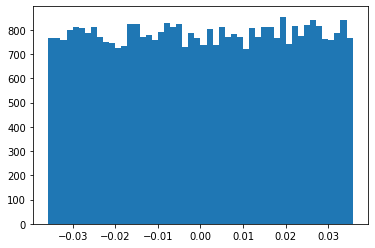

In [187]:
model1 = Network(28*28, 10, num_neurons=(50,), activation=[th.nn.Sigmoid()])
for name, param in model1.named_parameters():
    if 'bias' not in name:
        #print(param[0])
        t = param.detach().numpy().flatten()
        plt.hist(t, 50)
        break